# Moving Average

_Moving Average_ (MA) is an indicator that constantly describes the average price over a period. It's also called _rolling average_. The mean over the last $k$ data points can be calculated as:

$\displaystyle {\begin{aligned}{\textit {SMA}}_{k}={\frac {p_{n-k+1}+p_{n-k+2}\cdots +p_{n}}{k}}={\frac {1}{k}}\sum _{i=n-k+1}^{n}p_{i}\end{aligned}}$

Intuitively, the value for a 3 days moving average in a given date $t$ is computed by simply calculating the average of the previous 3 values: $(t + t_{-1} + t_{-2}) / 3$.

Luckily, Pandas comes with batteries included, offering us the `.rolling()` function, that accepts the number of days to use

In [1]:
import pandas as pd
from sample_data import stock_prices

msft = stock_prices('msft')
ma50 = msft.Close.rolling(50).mean()
ma200 = msft.Close.rolling(200).mean()

`ma50` is a Series with all the computed moving average values

In [2]:
ma50.tail(4)

Date
2022-06-28    266.840599
2022-06-29    266.435399
2022-06-30    265.865999
2022-07-01    265.330399
Name: Close, dtype: float64

Using `ma50` and `ma200`, we can plot them to observe the trends over time. Lines should follow the main price values, but you should observe a more _soft_ reactions to price changes.

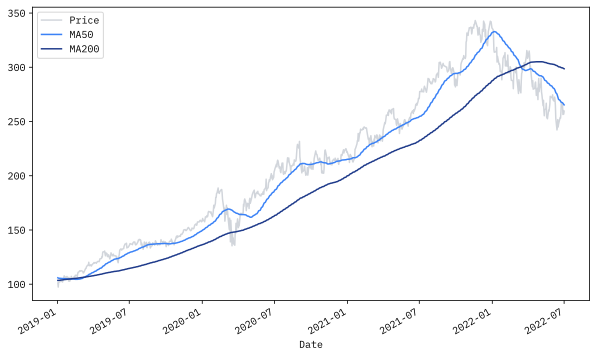

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['font.family'] = "IBM Plex Mono"

ig, ax = plt.subplots(figsize=(10,6))

msft.Close['2019':].plot(color='#D1D5DB', label="Price")
ma50['2019':].plot(color='#3B82F6', label="MA50")
ma200['2019':].plot(color='#1E3A8A', label="MA200")
plt.legend()
plt.show()

### Exercise 5.1

Read 2019 data for `aapl` and compute the moving average for the last 50 days using Spark.

### Exercise 5.2

Compute the same MA20, but this time by using [the new Pandas API for Spark](https://databricks.com/blog/2021/10/04/pandas-api-on-upcoming-apache-spark-3-2.html). 

There could be a warning message like this one: _No Partition Defined for Window operation_. What does it mean?

## Exponential Moving Average (EMA)

A variation of this is to use the _Exponential Moving Average (EMA)_, that gives more weight to recent prices. SMA represent the average of prices in a timespan, and are better suited to identify "resistance" levels. In contrast, EMA has less lag and is therefore more sensitive to recent prices.

Pandas offers us the `.ewm` function to calculate the Exponentially weighted windows.

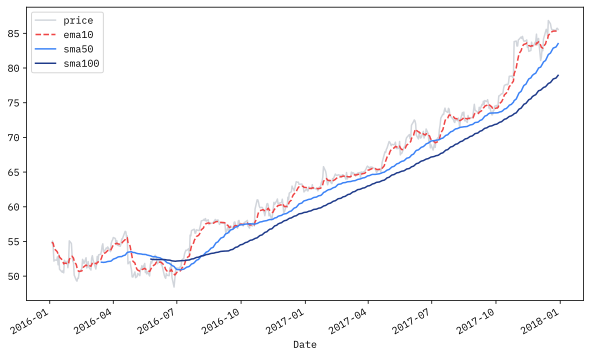

In [4]:
msft_2016 = msft['2016':'2017']
ema10 = msft_2016.Close.ewm(span=10, adjust=False).mean()
sma50 = msft_2016.Close.rolling(50).mean()
sma100 = msft_2016.Close.rolling(100).mean()

ig, ax = plt.subplots(figsize=(10,6))

msft_2016.Close.plot(ax=ax, color='#D1D5DB', label="price")
ema10.plot(ax=ax, color='#EF4444', linestyle="--", label="ema10")
sma50.plot(ax=ax, color='#3B82F6', label="sma50")
sma100.plot(ax=ax, color='#1E3A8A', label="sma100")
plt.legend()
plt.show()

One interesting thing about `ewm` is that it supports incremental updates. To use it, you have to call the `online` method right after `ewm` and that would return an object that allows to update the data with new data points.

In [5]:
online_ema10 = msft_2016.Close.ewm(span=10, adjust=False).online()
online_ema10.mean().tail(2)

Date
2017-12-28    85.460432
2017-12-29    85.474899
Name: Close, dtype: float64

In [6]:
online_ema10.mean(update=pd.Series([86.0]))

0    85.570372
dtype: float64

## MACD

There's another indicator called _Moving Average Convergence/Divergence oscillator (MACD)_. It's calculated by getting two moving averages and substracting the longer moving average by the sorter one. In the calculated MCDA below, negative MACD values indicate that the 12-day EMA is below the 26-day EMA.

In [7]:
ema12 = msft_2016.Close.ewm(span=12, adjust=False).mean()
ema26 = msft_2016.Close.ewm(span=26, adjust=False).mean()
macd = ema12 - ema26
macd

Date
2016-01-04    0.000000
2016-01-05    0.019943
2016-01-06   -0.044431
2016-01-07   -0.244333
2016-01-08   -0.385402
                ...   
2017-12-22    0.918154
2017-12-26    0.867302
2017-12-27    0.842306
2017-12-28    0.813922
2017-12-29    0.768049
Name: Close, Length: 503, dtype: float64

Additionally, we can calculate a _signal line_ that would identify events on the MACD when both lines cross. When signal line is below the MACD, things are improving over time.

<AxesSubplot:xlabel='Date'>

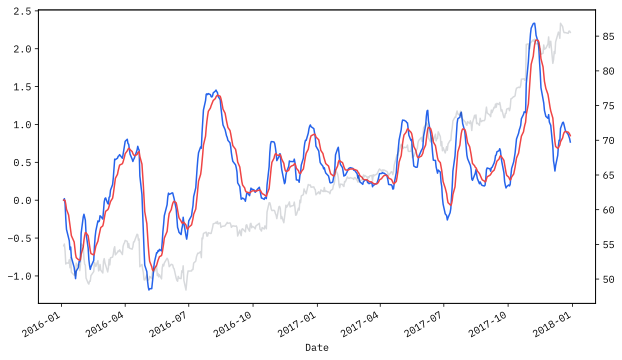

In [8]:
signal = macd.ewm(span=9, adjust=False).mean()

fig, ax = plt.subplots(figsize=(10,6))
msft_2016.Close.plot(ax=ax, color='#374151', alpha=0.2, secondary_y=True)
macd.plot(ax=ax, color='#2563EB')
signal.plot(ax=ax, color='#EF4444')